### Uploading the csv's

In [8]:
import pandas as pd
import os
import numpy as np
d1=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/1.csv')
d1=pd.DataFrame(d1)
d2=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/2.csv')
d2=pd.DataFrame(d2)
d3=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/3.csv')
d3=pd.DataFrame(d3)
d4=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/4.csv')
d4=pd.DataFrame(d4)
d5=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/5.csv')
d5=pd.DataFrame(d5)
d6=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/6.csv')
d6=pd.DataFrame(d6)
d7=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/7.csv')
d7=pd.DataFrame(d7)
d8=pd.read_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/8.csv')
d8=pd.DataFrame(d8)

dataset=[d1,d2,d3,d4,d5,d6,d7,d8]
df = pd.concat(dataset)
df=df.reset_index(drop=True)
df=df[df['links_Appartment_image1'].isnull()==False]
df=df.reset_index(drop=True)
df.info()

### URL Extraction

In [13]:
import re

for i in range(len(df.index)):

    text1 = df.loc[i,'links_Appartment_image1']
    text2 = df.loc[i,'links_Appartment_image2']
    text3 = df.loc[i,'links_Appartment_image3']

    try:
        found1 = re.search('https(.+?)position', text1).group(1)
        df.loc[i,'links_Appartment_image1']="https"+found1[:-4]

    except AttributeError:
        df.loc[i,'links_Appartment_image1'] = np.nan # apply your error handling
    except TypeError:
        pass
    try:
        found2 = re.search('https(.+?)position', text2).group(1)
        df.loc[i,'links_Appartment_image2']="https"+found2[:-4]

    except AttributeError:
        df.loc[i,'links_Appartment_image2'] = np.nan # apply your error handling
    except TypeError:
        pass
    try:
        found3 = re.search('https(.+?)position', text3).group(1)
        df.loc[i,'links_Appartment_image3']="https"+found3[:-4]

    except AttributeError:
        df.loc[i,'links_Appartment_image3'] = np.nan # apply your error handling
    except TypeError:
        pass

df = df.rename(columns={'links_Appartment_image1': 'links_image1_url','links_Appartment_image2': 'links_image2_url','links_Appartment_image3': 'links_image3_url'})

### Coordinate extraction

In [11]:
# Address transformation 
for i in range(len(df.index)):
    try:
        df.loc[i,'short_adress']=df.loc[i,'links_Appartment_Address'].partition("-")[0]
    except AttributeError:
        pass
    try:
        df.loc[i,'short_adress']=df.loc[i,'short_adress'].partition("SV")[0]
    except AttributeError:
        pass
    try:
        df.loc[i,'short_adress']=df.loc[i,'short_adress'].partition("NV")[0]
    except AttributeError:
        pass
    try:
        df.loc[i,'short_adress']=df.loc[i,'short_adress'].partition("C")[0]
    except AttributeError:
        pass
    try:
        str = df.loc[i,'short_adress'];
        df.loc[i,'short_adress'] = str.replace("Valby", "Copenhagen");
        df.loc[i,'short_adress'] = str.replace("Brønshøj", "Copenhagen");
        df.loc[i,'short_adress'] = str.replace("Nordvest", "Copenhagen");
    except AttributeError:
        pass

In [16]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='robertas.kazbaras@gmail.com')
for i in range(len(df.index)):
    try: 
        location = geolocator.geocode(df.loc[i,'short_adress'])
        df.loc[i,'latitude']=location.latitude
        df.loc[i,'longitude']=location.longitude
    except AttributeError:
        pass

In [24]:
#Taking non nul coordinates
df=df[df['latitude'].isnull()==False]
df=df.reset_index(drop=True)

#Using the geopy for CBS coordinates
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='robertas.kazbaras@gmail.com')
location = geolocator.geocode("Solbjerg Pl. 3, 2000, Copenhagen")
coords_1=(location.latitude,location.longitude)

#Calculating the distance
import geopy.distance
for i in range(len(df.index)):
    coords_2 = (df.loc[i,"latitude"],df.loc[i,"longitude"])
    df.loc[i,"distance to CBS"]= geopy.distance.geodesic(coords_1, coords_2).km

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   links_link                        718 non-null    object 
 1   links_Appartment_url              718 non-null    object 
 2   links_Appartment_Name             718 non-null    object 
 3   links_Appartment_Address          718 non-null    object 
 4   links_Appartment_Boligtype        718 non-null    object 
 5   links_Appartment_Rooms            718 non-null    float64
 6   links_Appartment_Floor            718 non-null    object 
 7   links_Appartment_Furnished        718 non-null    object 
 8   links_Appartment_Shareable        718 non-null    object 
 9   links_Appartment_Pets_allowed     718 non-null    object 
 10  links_Appartment_Rent_period      718 non-null    object 
 11  links_Appartment_Take_over_date   718 non-null    object 
 12  links_Ap

### Estimating the number of bedrooms

In [42]:
#Taking care of links_Appartment_Rent_monthly
df['links_Appartment_Rent_monthly'] = df['links_Appartment_Rent_monthly'].str[:-2]
df['links_Appartment_Rent_monthly'] =df['links_Appartment_Rent_monthly'].str.replace(r'.', '') # removed "."

#Changing the type into integer
df = df[~df['links_Appartment_Rent_monthly'].isnull()] # links_Appartment_Rent_monthly contained NaN

df['links_Appartment_Rent_monthly'] =df['links_Appartment_Rent_monthly'].astype(int)
df['links_Appartment_Rent_monthly']

0        400,-
1          0,-
2      1.000,-
3      1.100,-
4          0,-
        ...   
712        0,-
713        0,-
714        0,-
715        0,-
716        0,-
Name: links_Appartment_Aconto, Length: 717, dtype: object

In [ ]:
#Taking care of links_Appartment_Rent_monthly
df['links_Appartment_Aconto']=df['links_Appartment_Aconto'].str[:-2]
df['links_Appartment_Aconto'] =df['links_Appartment_Aconto'].str.replace(r'.', '') # removed "."

for i in range(len(df.index)):
    if df.loc[i,'links_Appartment_Aconto']=='':
        df.loc[i,'links_Appartment_Aconto']=0

df['links_Appartment_Aconto'] =df['links_Appartment_Aconto'].astype(int)
df['links_Appartment_Aconto']

In [29]:
# Deleting entries wiht more than 10 rooms
df=df[df['links_Appartment_Rooms']<10]
df=df.reset_index(drop=True)

In [61]:
#The bedrooms can be estimated with around 90% accuracy by subtracting one in apartments with two to four rooms and two with five and six
df['links_Appartment_Rooms']=df['links_Appartment_Rooms'].astype(int)
for i in range(len(df.index)):
    if df.loc[i,'links_Appartment_Rooms']>1 & df.loc[i,'links_Appartment_Rooms']<5:
        df.loc[i,'Bedrooms']=df.loc[i,'links_Appartment_Rooms']-1
    if df.loc[i,'links_Appartment_Rooms']>4:
        df.loc[i,'Bedrooms']=df.loc[i,'links_Appartment_Rooms']-2
    if df.loc[i,'links_Appartment_Rooms']==1:
        df.loc[i,'Bedrooms']=df.loc[i,'links_Appartment_Rooms']

### Including price per bedroom calculations

In [62]:
# taking care of links_rent_aconto_monthly
df['links_rent_aconto_monthly']=df['links_Appartment_Rent_monthly']+df['links_Appartment_Aconto']
a=df[df['links_rent_aconto_monthly'].isnull()].index
for i in range(len(a)):
    df.loc[a[i],'links_rent_aconto_monthly']=df.loc[a[i],'links_Appartment_Rent_monthly']
df['links_rent_aconto_monthly']

0       8200
1       4500
2      15700
3      18200
4       6000
       ...  
712     6000
713     5250
714     4800
715     4750
716     4500
Name: links_rent_aconto_monthly, Length: 717, dtype: int64

In [63]:
# links_Appartment_Rooms to integers
df['Bedrooms']=df['Bedrooms'].astype(int)

# taking care of links_rent_aconto_monthly
df['links_rent_aconto_monthly']=df['links_Appartment_Rent_monthly']+df['links_Appartment_Aconto']
a=df[df['links_rent_aconto_monthly'].isnull()].index
for i in range(len(a)):
    df.loc[a[i],'links_rent_aconto_monthly']=df.loc[a[i],'links_Appartment_Rent_monthly']
df['links_rent_aconto_monthly']=df['links_rent_aconto_monthly'].astype(int)
    
# calculate Price_per_room
# using apply function to create a new column 
df['Price_per_bedroom'] = df['links_rent_aconto_monthly']/df['Bedrooms']
# Print the DataFrame after addition of new column 
df = df.fillna(0)
df['Price_per_bedroom'] =df['Price_per_bedroom'].astype(int)

In [64]:
# Deleting apartments that are more than 10k per bedroom
df=df[df['Price_per_bedroom'] < 10000]
df=df.reset_index(drop=True)

#creating a new column with score rating/points
def rating_price(df):
    if (df['Price_per_bedroom'] < 3000):
        return 5
    elif (df['Price_per_bedroom'] < 4000):
        return 4
    elif (df['Price_per_bedroom'] < 5000):
        return 3
    elif (df['Price_per_bedroom'] < 6000):
        return 2
    elif (df['Price_per_bedroom'] < 7000):
        return 1
    elif (df['Price_per_bedroom'] < 8000):
        return 0
    elif (df['Price_per_bedroom'] > 8000):
        return np.nan
    
df['Price_score'] = df.apply(rating_price, axis = 1)
df = df.fillna(0)
df['Price_score'] = df['Price_score'].astype(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd60b0a52d0>]],
      dtype=object)

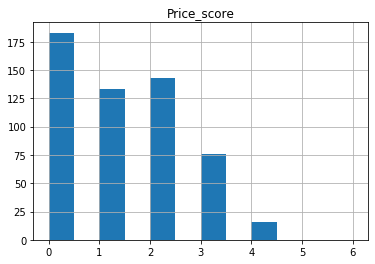

In [65]:
# histogram
%matplotlib inline 
#to plot charts into Jupyter Notebook
df.hist('Price_score', bins=12, range=[0, 6])

### Distance score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd60b06e810>]],
      dtype=object)

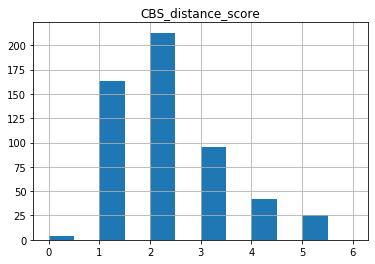

In [67]:
#cleaning up distance that is unrealisticly too far away:
df=df[df['distance to CBS'] < 14]
df=df.reset_index(drop=True)

#creating a new column with score rating/points
def rating_price(df):
    if (df['distance to CBS'] < 1):
        return 5
    elif (df['distance to CBS'] < 2):
        return 4
    elif (df['distance to CBS'] < 3):
        return 3
    elif (df['distance to CBS'] < 5):
        return 2
    elif (df['distance to CBS'] < 8):
        return 1
    elif (df['distance to CBS'] < 14):
        return 0
    elif (df['distance to CBS'] > 14):
        return np.nan
    
df['CBS_distance_score'] = df.apply(rating_price, axis = 1)
df = df.fillna(0)
df['CBS_distance_score'] = df['CBS_distance_score'].astype(int)

# histogram
%matplotlib inline 
#to plot charts into Jupyter Notebook
df.hist('CBS_distance_score', bins=12, range=[0, 6])

### Saving data

In [73]:
df=df.drop(['links_link'], axis=1)
df.to_csv('/Users/kazba1/Desktop/RE valuation modelling/Additional data/Additional_data_11_12.csv')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   links_Appartment_url              543 non-null    object 
 1   links_Appartment_Name             543 non-null    object 
 2   links_Appartment_Address          543 non-null    object 
 3   links_Appartment_Boligtype        543 non-null    object 
 4   links_Appartment_Rooms            543 non-null    int64  
 5   links_Appartment_Floor            543 non-null    object 
 6   links_Appartment_Furnished        543 non-null    object 
 7   links_Appartment_Shareable        543 non-null    object 
 8   links_Appartment_Pets_allowed     543 non-null    object 
 9   links_Appartment_Rent_period      543 non-null    object 
 10  links_Appartment_Take_over_date   543 non-null    object 
 11  links_Appartment_Rent_monthly     543 non-null    int64  
 12  links_Ap